## Fraud Detection in Banking

### Module Imports

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import EngFormatter #handles units in the axis
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

### Data Import and Data Exploration

In [211]:
df = pd.read_csv("Bank_Transaction_Fraud_Detection.csv") #import data
df.head(2)

,Customer_ID,Customer_Name,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_ID,Transaction_Date,...,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Customer_Contact,Transaction_Description,Customer_Email
0,d5f6ec07-d69e-4f47-b9b4-7c58ff17c19e,Osha Tella,Male,60,Kerala,Thiruvananthapuram,Thiruvananthapuram Branch,Savings,4fa3208f-9e23-42dc-b330-844829d0c12c,23-01-2025,...,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,INR,+9198579XXXXXX,Bitcoin transaction,oshaXXXXX@XXXXX.com
1,7c14ad51-781a-4db9-b7bd-67439c175262,Hredhaan Khosla,Female,51,Maharashtra,Nashik,Nashik Branch,Business,c9de0c06-2c4c-40a9-97ed-3c7b8f97c79c,11-01-2025,...,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,INR,+9191074XXXXXX,Grocery delivery,hredhaanXXXX@XXXXXX.com


#### Lets understand our data in terms of:
- No. of records
- No. of variables 
- The data types
- Missing values
- Are there duplicates

In [212]:
df.shape #rows versus columns

(200000, 24)

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Customer_ID              200000 non-null  object 
 1   Customer_Name            200000 non-null  object 
 2   Gender                   200000 non-null  object 
 3   Age                      200000 non-null  int64  
 4   State                    200000 non-null  object 
 5   City                     200000 non-null  object 
 6   Bank_Branch              200000 non-null  object 
 7   Account_Type             200000 non-null  object 
 8   Transaction_ID           200000 non-null  object 
 9   Transaction_Date         200000 non-null  object 
 10  Transaction_Time         200000 non-null  object 
 11  Transaction_Amount       200000 non-null  float64
 12  Merchant_ID              200000 non-null  object 
 13  Transaction_Type         200000 non-null  object 
 14  Merc

In [214]:
nulls = df.isnull().sum().sum()
nas = df.isna().sum().sum()
print("nulls:", nulls)
print("nas:",nas)

nulls: 0
nas: 0


In [215]:
duplicates = df.duplicated().sum()
print("duplicates:", duplicates)


duplicates: 0


#### Observation
- 200000 records
- 24 variables
- 4 numerical variables
- 20 categorical variables
- No missing values observed
- since some features are categorical we will have to do label encoding to convert them to numerical later for modelling.

#### Exploring the columns for further analysis
- what's in the columns?
- what are the uniques values is these columns?
- How many customers? Are there repeat customers?
- are there Duplicates transactions

In [216]:
df.columns

Index(['Customer_ID', 'Customer_Name', 'Gender', 'Age', 'State', 'City',
       'Bank_Branch', 'Account_Type', 'Transaction_ID', 'Transaction_Date',
       'Transaction_Time', 'Transaction_Amount', 'Merchant_ID',
       'Transaction_Type', 'Merchant_Category', 'Account_Balance',
       'Transaction_Device', 'Transaction_Location', 'Device_Type', 'Is_Fraud',
       'Transaction_Currency', 'Customer_Contact', 'Transaction_Description',
       'Customer_Email'],
      dtype='object')

In [217]:
no_of_customers = df["Customer_ID"].nunique()
print("no_of_customer: ", no_of_customers)
no_of_transactions = df["Transaction_ID"].str.lower().nunique()
print("No_of_transactions: ", no_of_transactions)

no_of_customer:  200000
No_of_transactions:  200000


#### Observation
- A total of 200000 customers, so we have no repeat customers
- A total of 200000 unique transactions

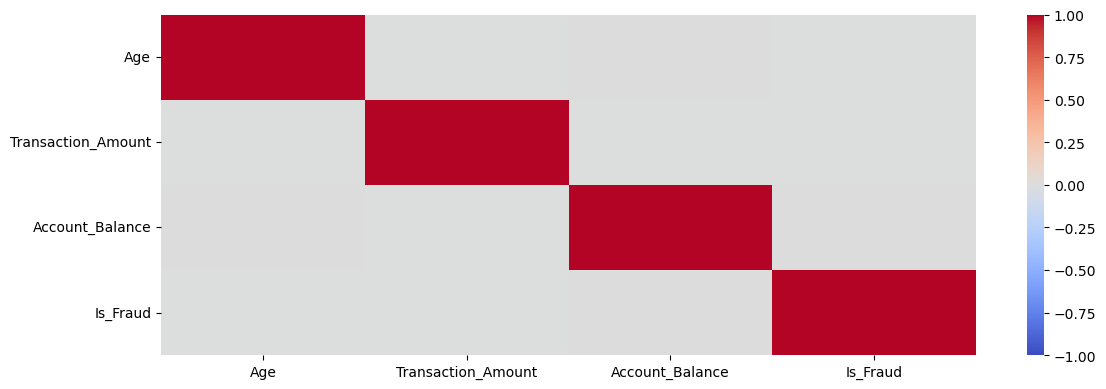

In [218]:
fig,ax = plt.subplots(figsize=(12,4))

df_numeric = df.select_dtypes(include=['number'])
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, vmax=1, vmin=-1, cmap="coolwarm", ax=ax)
plt.tight_layout()
plt.show()

#### Observation
- That dats as it is, has no correlation. We will revist the correlation check after doing some feature engineering

In [219]:
df.describe()

,Age,Transaction_Amount,Account_Balance,Is_Fraud
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,44.015110,49538.015554,52437.988784,0.050440
std,15.288774,28551.874004,27399.507128,0.218852
min,18.000000,10.290000,5000.820000,0.000000
25%,31.000000,24851.345000,28742.395000,0.000000
50%,44.000000,49502.440000,52372.555000,0.000000
75%,57.000000,74314.625000,76147.670000,0.000000
max,70.000000,98999.980000,99999.950000,1.000000


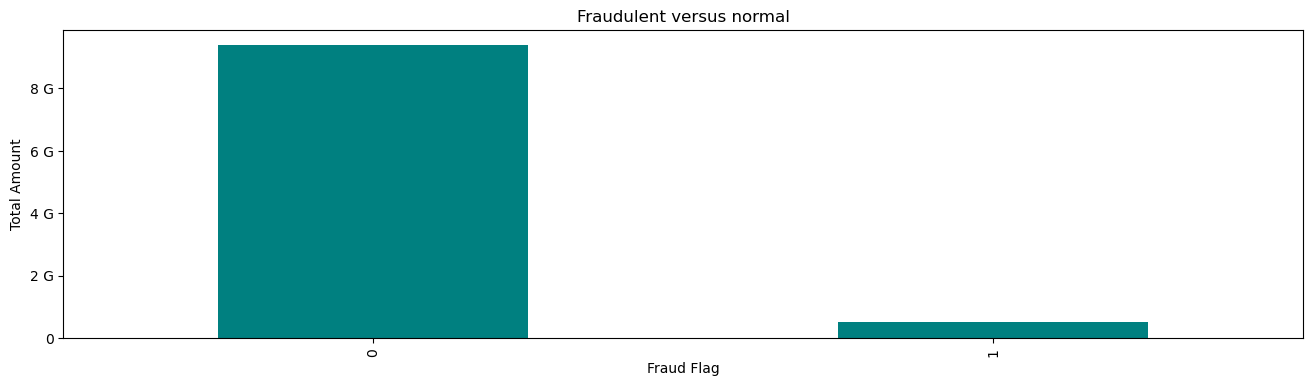

In [220]:
fig, ax = plt.subplots(figsize=(16,4))

df.groupby("Is_Fraud")["Transaction_Amount"].sum().plot(kind="bar", color="teal", ax=ax)

ax.yaxis.set_major_formatter(EngFormatter())
plt.ylabel("Total Amount")
plt.xlabel("Fraud Flag")
plt.title("Fraudulent versus normal")
plt.show()

In [221]:
is_fraud_df = df[df["Is_Fraud"] == 1]
is_fraud_df.shape

(10088, 24)

In [222]:
fraud_rate = (is_fraud_df.shape[0] / df.shape[0]) * 100
fraud_rate

5.044

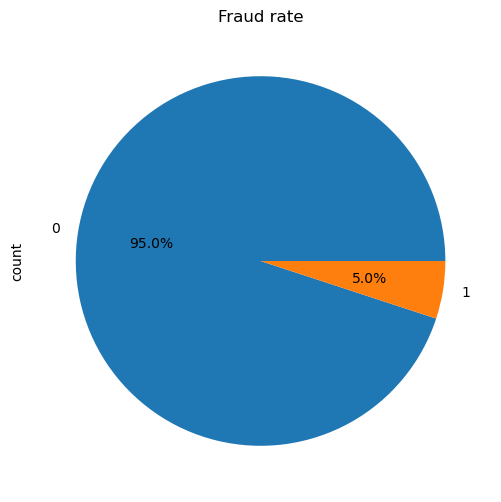

In [223]:
fig, ax = plt.subplots(figsize=(6,6))
df["Is_Fraud"].value_counts().plot(kind="pie",autopct="%1.1f%%",ax=ax)
plt.title("Fraud rate")
plt.show()

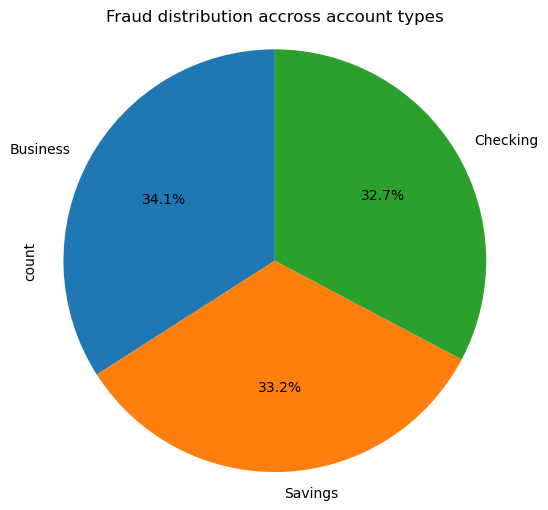

In [224]:
fig, ax = plt.subplots(figsize=(6,6))

is_fraud_df["Account_Type"].value_counts().plot(kind="pie", autopct="%1.1f%%",ax=ax, startangle=90)

plt.title("Fraud distribution accross account types")
plt.axis("equal")
plt.show()

In [225]:
is_fraud_df.describe()

,Age,Transaction_Amount,Account_Balance,Is_Fraud
count,10088.000000,10088.000000,10088.000000,10088.0
mean,43.914453,49277.925242,52452.891412,1.0
std,15.265150,28739.518843,27300.467424,0.0
min,18.000000,10.410000,5003.420000,1.0
25%,31.000000,24420.042500,29122.987500,1.0
50%,44.000000,49162.945000,52344.725000,1.0
75%,57.000000,74068.717500,76116.032500,1.0
max,70.000000,98999.020000,99999.950000,1.0


#### Fraud Distribution Accross States

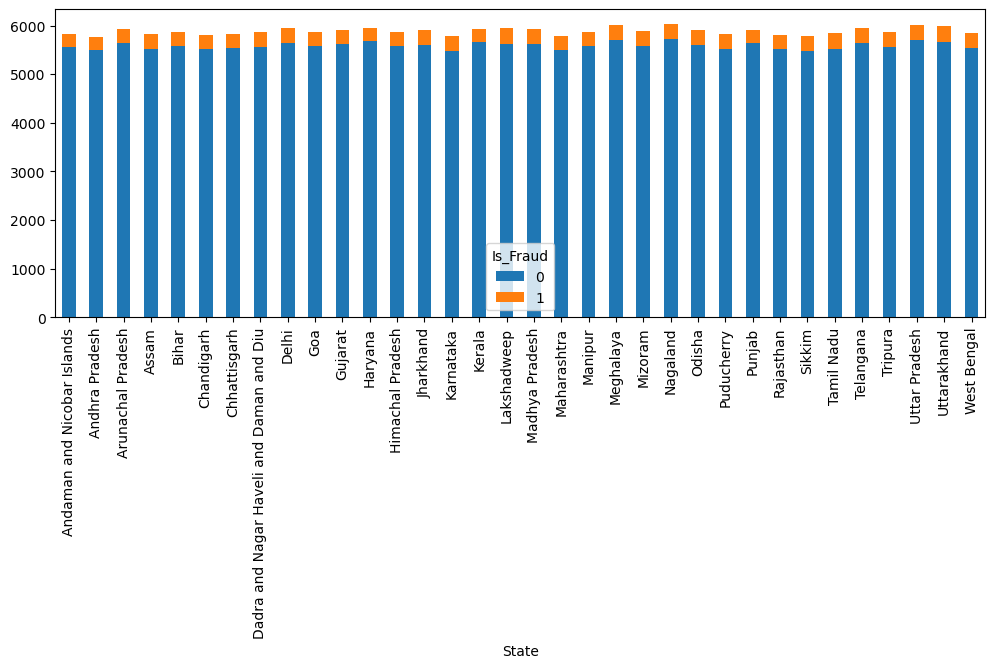

In [226]:
fig,ax = plt.subplots(figsize=(12,4))
cross_tab = pd.crosstab(df["State"],df["Is_Fraud"])

cross_tab.plot(kind="bar", stacked=True, ax=ax)
plt.xticks(rotation=90)
plt.show()

- Fraud seems to be equally distributed accross the states

#### Checking the unique values in each column


In [227]:

cols = df.columns
summary_dict = {}
for col in cols:
    if df[col].dtypes == "object" or df[col].dtypes == "string":
        summary_dict[f"{col}_totals"] = df[col].str.strip().str.lower().nunique()

    else:
        summary_dict[f"{col}_totals"] = df[col].nunique()

summary_dict = pd.DataFrame(list(summary_dict.items()), columns=["Column_Name","Unique_count"])
summary_dict

,Column_Name,Unique_count
0,Customer_ID_totals,200000
1,Customer_Name_totals,142699
2,Gender_totals,2
3,Age_totals,53
4,State_totals,34
5,City_totals,145
6,Bank_Branch_totals,145
7,Account_Type_totals,3
8,Transaction_ID_totals,200000
9,Transaction_Date_totals,31


- We can drop the currecy column since its only 1

In [228]:
bal_less_than_0_df = df[df["Account_Balance"] <= 0]
bal_less_than_0_df.shape[0]

0

- initially we have no accounts with less than 0

In [229]:
transaction_bigger_than_bal = df[df["Transaction_Amount"] > df["Account_Balance"]]
transaction_bigger_than_bal.shape[0]

94071

- We have some transactions that are larger than the account balance which means the account is left negative after the transaction. This could be an overdraft in some cases

In [230]:
transaction_bigger_than_bal[transaction_bigger_than_bal["Is_Fraud"] == 1].shape[0]

4705

- These transactions that leave an account 4705 of them have been classified as fraudulent

In [231]:
nulls = df.isnull().sum().sum()
nulls

0

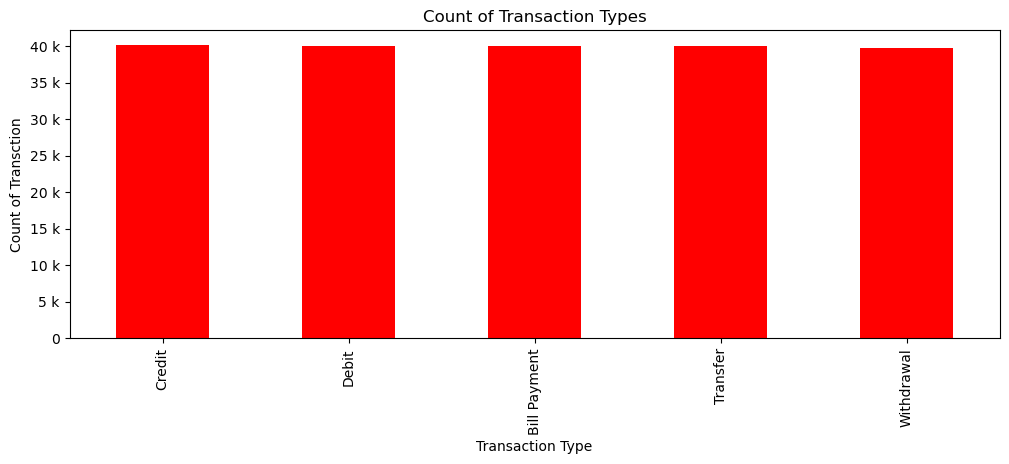

In [232]:
fig, ax = plt.subplots(figsize=(12,4))

df["Transaction_Type"].value_counts().plot(kind='bar',color='red', ax=ax) #groupby transaxtiontype and get count of each
ax.yaxis.set_major_formatter(EngFormatter()) #Handle x axis units

plt.xlabel("Transaction Type")
plt.ylabel("Count of Transction")
plt.title("Count of Transaction Types")

plt.show()

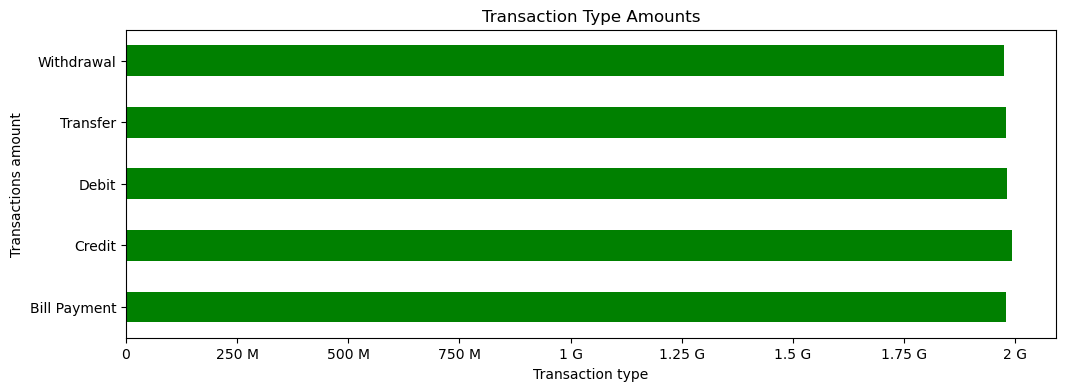

In [233]:
fig, ax = plt.subplots(figsize=(12,4))

df.groupby("Transaction_Type")["Transaction_Amount"].sum().plot(kind="barh", color="green", ax=ax)

ax.xaxis.set_major_formatter(EngFormatter()) #units conversion in axis

plt.xlabel("Transaction type")
plt.ylabel("Transactions amount")
plt.title("Transaction Type Amounts")
plt.show()

In [234]:
df.columns

Index(['Customer_ID', 'Customer_Name', 'Gender', 'Age', 'State', 'City',
       'Bank_Branch', 'Account_Type', 'Transaction_ID', 'Transaction_Date',
       'Transaction_Time', 'Transaction_Amount', 'Merchant_ID',
       'Transaction_Type', 'Merchant_Category', 'Account_Balance',
       'Transaction_Device', 'Transaction_Location', 'Device_Type', 'Is_Fraud',
       'Transaction_Currency', 'Customer_Contact', 'Transaction_Description',
       'Customer_Email'],
      dtype='object')

### Account Type Analysis

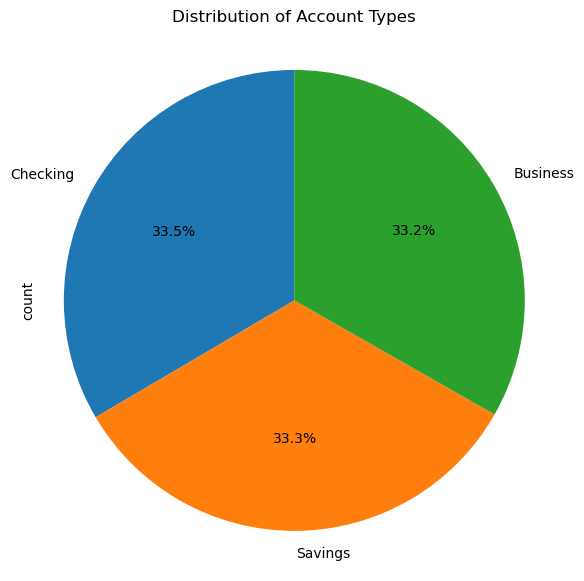

In [235]:
fig,ax = plt.subplots(figsize=(6,6))

df["Account_Type"].value_counts().plot(kind="pie", autopct='%1.1f%%', ax=ax, startangle=90)

plt.title("Distribution of Account Types")
plt.axis("equal")
plt.tight_layout()
plt.show()

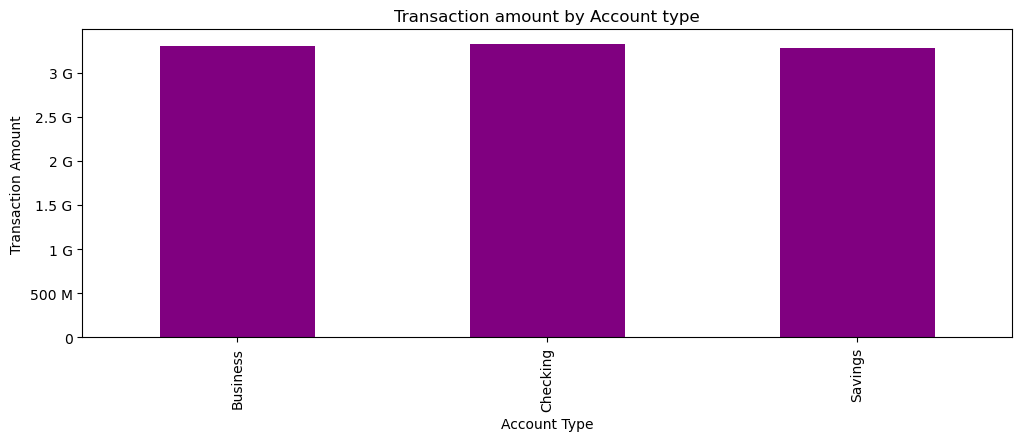

In [236]:
fig,ax = plt.subplots(figsize=(12,4))

df.groupby("Account_Type")["Transaction_Amount"].sum().plot(kind='bar',color='purple', ax=ax)

ax.yaxis.set_major_formatter(EngFormatter())
plt.title("Transaction amount by Account type")
plt.xlabel("Account Type")
plt.ylabel("Transaction Amount")
plt.show()



In [237]:
cols = df.select_dtypes(include=["object","string"])
cat_cols = cols.columns
cat_cols

Index(['Customer_ID', 'Customer_Name', 'Gender', 'State', 'City',
       'Bank_Branch', 'Account_Type', 'Transaction_ID', 'Transaction_Date',
       'Transaction_Time', 'Merchant_ID', 'Transaction_Type',
       'Merchant_Category', 'Transaction_Device', 'Transaction_Location',
       'Device_Type', 'Transaction_Currency', 'Customer_Contact',
       'Transaction_Description', 'Customer_Email'],
      dtype='object')

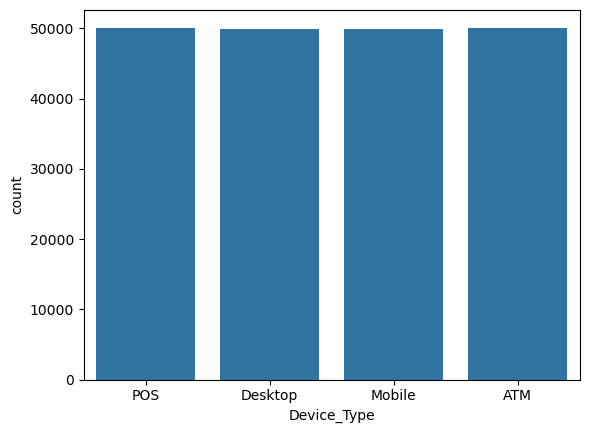

In [238]:
sns.countplot(data=df, x="Device_Type")
plt.show()

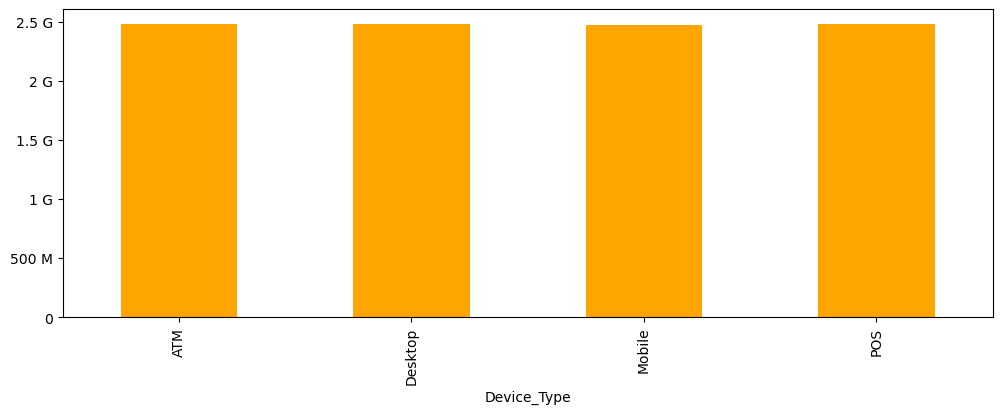

In [239]:
fig, ax = plt.subplots(figsize=(12,4))
amount_df = df.groupby("Device_Type")["Transaction_Amount"].sum()
amount_df.plot(kind="bar", color="orange",ax=ax)
ax.yaxis.set_major_formatter(EngFormatter())
plt.show()

### Feature Engineering

Checking the balance after a transaction will help in determining if a transaction is fraudulent especially if it depletes an account or leaves an amount that is close to depletion.

In [240]:
# Feature 1
df["after_transaction"] = df["Account_Balance"] - df["Transaction_Amount"] #checking balance after transaction
df.describe()

,Age,Transaction_Amount,Account_Balance,Is_Fraud,after_transaction
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,44.015110,49538.015554,52437.988784,0.050440,2899.973229
std,15.288774,28551.874004,27399.507128,0.218852,39606.279997
min,18.000000,10.290000,5000.820000,0.000000,-93714.400000
25%,31.000000,24851.345000,28742.395000,0.000000,-25579.012500
50%,44.000000,49502.440000,52372.555000,0.000000,2925.565000
75%,57.000000,74314.625000,76147.670000,0.000000,31361.772500
max,70.000000,98999.980000,99999.950000,1.000000,99719.480000


In [241]:
less_than_0_df = df[df['after_transaction'] < 0]
less_than_0_df.shape[0]

94071

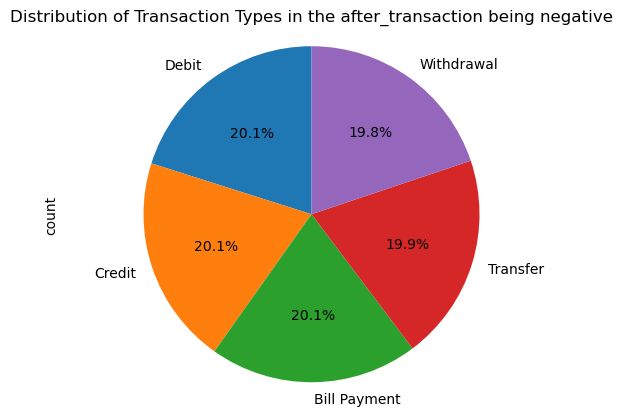

In [242]:
less_than_0_df["Transaction_Type"].value_counts().plot(kind="pie", autopct="%1.1f%%", startangle=90)
plt.title("Distribution of Transaction Types in the after_transaction being negative")
plt.axis('equal')
plt.show()

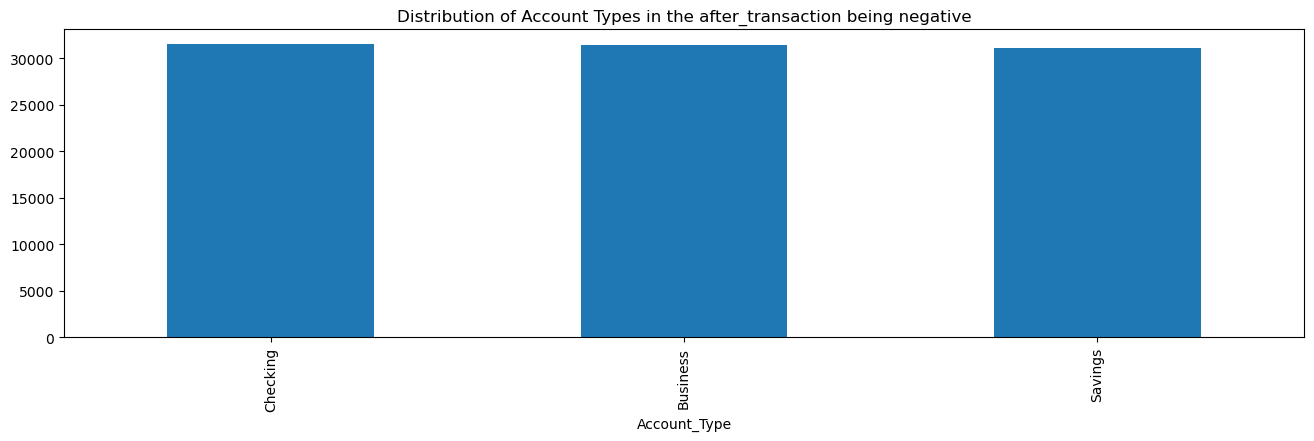

In [243]:
fig,ax = plt.subplots(figsize=(16,4))
less_than_0_df["Account_Type"].value_counts().plot(kind='bar',ax=ax)
plt.title("Distribution of Account Types in the after_transaction being negative")
plt.show()

<Axes: >

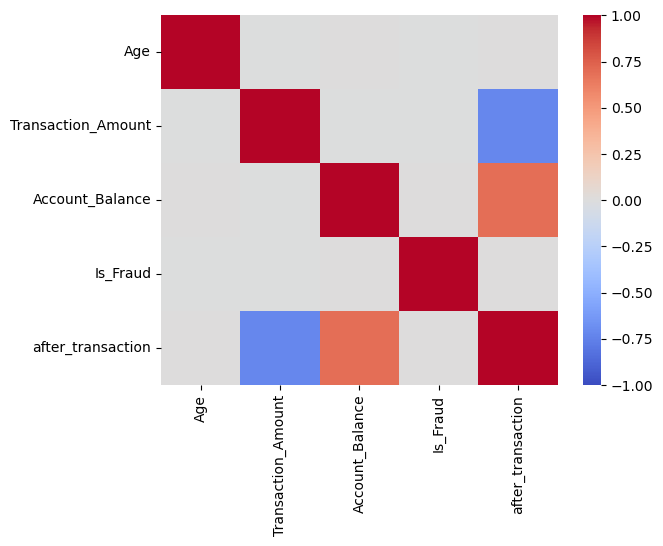

In [244]:
correlation_matrix = df.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", vmax=1,vmin=-1)

In [245]:
# Feature 2
# Withdrawal Percentage
df["withdrawal_rate"] = df['Transaction_Amount']/df['Account_Balance'] 

# feature 3
# Defining an overdraft
df["is_overdraft"] = np.where(df["withdrawal_rate"] > 1, 1,0)
df.head(1)

,Customer_ID,Customer_Name,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_ID,Transaction_Date,...,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Customer_Contact,Transaction_Description,Customer_Email,after_transaction,withdrawal_rate,is_overdraft
0,d5f6ec07-d69e-4f47-b9b4-7c58ff17c19e,Osha Tella,Male,60,Kerala,Thiruvananthapuram,Thiruvananthapuram Branch,Savings,4fa3208f-9e23-42dc-b330-844829d0c12c,23-01-2025,...,"Thiruvananthapuram, Kerala",POS,0,INR,+9198579XXXXXX,Bitcoin transaction,oshaXXXXX@XXXXX.com,42141.82,0.434772,0


#### I have just engineered 3 more features. I will first train using this 


### Train Test Spliting

### Feature Scaling